In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
class _NonLocalBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, dimension=3, sub_sample=True, bn_layer=True):
        super(_NonLocalBlockND, self).__init__()

        assert dimension in [1, 2, 3]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(self.in_channels)
            )
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)
        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x):
        '''
        :param x: (b, c, t, h, w)
        :return:
        '''

        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
        f = torch.matmul(theta_x, phi_x)
        f_div_C = F.softmax(f, dim=-1)

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        return z

In [3]:
class NONLocalBlock2D(_NonLocalBlockND):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NONLocalBlock2D, self).__init__(in_channels,
                                              inter_channels=inter_channels,
                                              dimension=2, sub_sample=sub_sample,
                                              bn_layer=bn_layer)


In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            NONLocalBlock2D(in_channels=32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            NONLocalBlock2D(in_channels=64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=256, out_features=10)
        )

    def forward(self, x):
        batch_size = x.size(0)
        output = self.convs(x).view(batch_size, -1)
        output = self.fc(output)
        return output

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Network().to(device=device)

In [6]:
x = torch.randn(5, 3, 32, 32)
x = x.to(device=device)
y = model(x)
print(y.shape)
print(y)

torch.Size([5, 10])
tensor([[ 0.2920,  0.7264,  0.3030, -0.5544, -0.2633, -0.1413, -0.7595, -0.0688,
          0.1306,  0.2849],
        [-0.0236,  0.4226,  1.1932, -0.7963,  0.4567, -0.3987, -0.7754,  0.8172,
          0.2855, -0.0635],
        [-0.0313,  0.2328,  0.1383, -0.8032,  0.4343, -0.0905, -0.4236,  0.3018,
          0.0284,  0.0596],
        [ 0.4583, -0.2698,  0.9710, -0.5640, -0.0644, -0.2062,  0.3139, -0.0715,
          0.4818, -0.4890],
        [ 0.1546, -0.2443,  0.5595, -0.6164,  0.1573, -0.0802,  0.1909,  0.1701,
         -0.0754, -0.0470]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [7]:
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm

In [8]:
# Hyperparameters
in_channels = 3
num_classes = 10
learning_rate = 3e-4 # karpathy's constant
batch_size = 64
num_epochs = 100

In [9]:
train_dataset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

bird


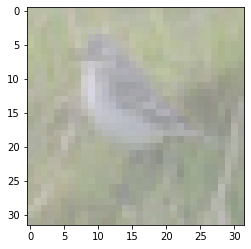

In [13]:
print(classes[labels[63]])
imshow(torchvision.utils.make_grid(images[63]))

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
    print('Epoch:', epoch, 'Loss:', loss.item())

  2%|█▏                                                                               | 12/782 [00:00<00:13, 58.66it/s]

Epoch: 0 Loss: 1.8480560779571533


  1%|▋                                                                                 | 6/782 [00:00<00:13, 59.39it/s]

Epoch: 1 Loss: 0.5261842012405396


  1%|▋                                                                                 | 6/782 [00:00<00:13, 56.06it/s]

Epoch: 2 Loss: 0.8536378145217896


  1%|▋                                                                                 | 7/782 [00:00<00:12, 61.63it/s]

Epoch: 3 Loss: 0.8127990365028381


  1%|▋                                                                                 | 7/782 [00:00<00:12, 62.49it/s]

Epoch: 4 Loss: 1.237208366394043


  1%|▌                                                                                 | 5/782 [00:00<00:16, 47.61it/s]

Epoch: 5 Loss: 0.9615095257759094


  1%|▋                                                                                 | 6/782 [00:00<00:13, 58.81it/s]

Epoch: 6 Loss: 0.6109560132026672


  1%|▋                                                                                 | 7/782 [00:00<00:12, 62.19it/s]

Epoch: 7 Loss: 0.4934321641921997


  1%|▋                                                                                 | 7/782 [00:00<00:12, 61.10it/s]

Epoch: 8 Loss: 0.8231900334358215


  1%|▌                                                                                 | 5/782 [00:00<00:15, 49.99it/s]

Epoch: 9 Loss: 0.42432984709739685


  1%|▋                                                                                 | 6/782 [00:00<00:13, 59.35it/s]

Epoch: 10 Loss: 0.472578227519989


  1%|▋                                                                                 | 7/782 [00:00<00:12, 61.10it/s]

Epoch: 11 Loss: 0.5697790384292603


  2%|█▏                                                                               | 12/782 [00:00<00:13, 58.01it/s]

Epoch: 12 Loss: 0.46433356404304504


  1%|▋                                                                                 | 7/782 [00:00<00:12, 60.86it/s]

Epoch: 13 Loss: 0.6236689686775208


  1%|▋                                                                                 | 6/782 [00:00<00:14, 53.40it/s]

Epoch: 14 Loss: 1.0025529861450195


  1%|▋                                                                                 | 6/782 [00:00<00:13, 56.31it/s]

Epoch: 15 Loss: 0.17032039165496826


  1%|▋                                                                                 | 6/782 [00:00<00:13, 59.67it/s]

Epoch: 16 Loss: 0.2894672155380249


  2%|█▏                                                                               | 12/782 [00:00<00:12, 59.89it/s]

Epoch: 17 Loss: 0.21237453818321228


  1%|▋                                                                                 | 6/782 [00:00<00:14, 54.76it/s]

Epoch: 18 Loss: 0.6365510821342468


  1%|▋                                                                                 | 7/782 [00:00<00:12, 61.37it/s]

Epoch: 19 Loss: 0.6546126008033752


  1%|▋                                                                                 | 7/782 [00:00<00:12, 62.49it/s]

Epoch: 20 Loss: 0.08826993405818939


  1%|▋                                                                                 | 7/782 [00:00<00:12, 61.64it/s]

Epoch: 21 Loss: 0.3703422248363495


  1%|▋                                                                                 | 7/782 [00:00<00:12, 61.93it/s]

Epoch: 22 Loss: 0.22801709175109863


  1%|▋                                                                                 | 6/782 [00:00<00:13, 56.79it/s]

Epoch: 23 Loss: 0.04935513436794281


  1%|▋                                                                                 | 7/782 [00:00<00:12, 60.86it/s]

Epoch: 24 Loss: 0.4336696267127991


  1%|▋                                                                                 | 6/782 [00:00<00:14, 54.76it/s]

Epoch: 25 Loss: 0.3661639392375946


  1%|▋                                                                                 | 7/782 [00:00<00:12, 61.64it/s]

Epoch: 26 Loss: 0.22040191292762756


  1%|▋                                                                                 | 6/782 [00:00<00:13, 58.81it/s]

Epoch: 27 Loss: 0.056169334799051285


  2%|█▏                                                                               | 12/782 [00:00<00:13, 59.04it/s]

Epoch: 28 Loss: 0.5158359408378601


  1%|▋                                                                                 | 6/782 [00:00<00:13, 58.24it/s]

Epoch: 29 Loss: 0.08393602073192596


  2%|█▎                                                                               | 13/782 [00:00<00:13, 58.41it/s]

Epoch: 30 Loss: 0.033600252121686935


  1%|▋                                                                                 | 7/782 [00:00<00:12, 59.79it/s]

Epoch: 31 Loss: 0.14843960106372833


  1%|▋                                                                                 | 6/782 [00:00<00:13, 57.65it/s]

Epoch: 32 Loss: 0.08179222047328949


  1%|▋                                                                                 | 6/782 [00:00<00:14, 55.27it/s]

Epoch: 33 Loss: 0.18360288441181183


  1%|▋                                                                                 | 6/782 [00:00<00:13, 58.24it/s]

Epoch: 34 Loss: 0.007277147378772497


  1%|▋                                                                                 | 7/782 [00:00<00:12, 61.64it/s]

Epoch: 35 Loss: 0.06791487336158752


  1%|▋                                                                                 | 6/782 [00:00<00:13, 58.81it/s]

Epoch: 36 Loss: 0.15773950517177582


  1%|▋                                                                                 | 6/782 [00:00<00:14, 55.03it/s]

Epoch: 37 Loss: 0.002883446868509054


  1%|▋                                                                                 | 6/782 [00:00<00:13, 57.73it/s]

Epoch: 38 Loss: 0.06357623636722565


  1%|▌                                                                                 | 5/782 [00:00<00:16, 48.28it/s]

Epoch: 39 Loss: 0.07341606914997101


  1%|▋                                                                                 | 7/782 [00:00<00:13, 57.11it/s]

Epoch: 40 Loss: 0.07674621790647507


  1%|▋                                                                                 | 6/782 [00:00<00:13, 58.24it/s]

Epoch: 41 Loss: 0.22802484035491943


  2%|█▏                                                                               | 12/782 [00:00<00:13, 57.75it/s]

Epoch: 42 Loss: 0.04166227579116821


  1%|▋                                                                                 | 6/782 [00:00<00:13, 59.39it/s]

Epoch: 43 Loss: 0.37866002321243286


  1%|▋                                                                                 | 6/782 [00:00<00:13, 57.06it/s]

Epoch: 44 Loss: 0.07356578856706619


  2%|█▏                                                                               | 12/782 [00:00<00:13, 58.54it/s]

Epoch: 45 Loss: 0.0428299605846405


  1%|▋                                                                                 | 6/782 [00:00<00:13, 58.23it/s]

Epoch: 46 Loss: 0.0012009500060230494


  1%|▋                                                                                 | 6/782 [00:00<00:13, 57.39it/s]

Epoch: 47 Loss: 0.028139298781752586


  1%|▋                                                                                 | 6/782 [00:00<00:14, 54.26it/s]

Epoch: 48 Loss: 0.3353082835674286


  1%|▋                                                                                 | 6/782 [00:00<00:14, 55.05it/s]

Epoch: 49 Loss: 0.15306700766086578


  1%|▋                                                                                 | 6/782 [00:00<00:13, 56.59it/s]

Epoch: 50 Loss: 0.0031426288187503815


  1%|▋                                                                                 | 6/782 [00:00<00:14, 54.50it/s]

Epoch: 51 Loss: 0.11148339509963989


  2%|█▏                                                                               | 12/782 [00:00<00:13, 57.79it/s]

Epoch: 52 Loss: 0.051442816853523254


  1%|▌                                                                                 | 5/782 [00:00<00:16, 45.77it/s]

Epoch: 53 Loss: 0.1486065536737442


  1%|▋                                                                                 | 6/782 [00:00<00:14, 52.37it/s]

Epoch: 54 Loss: 0.09708645939826965


  1%|▋                                                                                 | 6/782 [00:00<00:14, 53.09it/s]

Epoch: 55 Loss: 0.05917365849018097


  1%|▌                                                                                 | 5/782 [00:00<00:16, 46.29it/s]

Epoch: 56 Loss: 0.005841236561536789


  1%|█▏                                                                               | 11/782 [00:00<00:13, 56.02it/s]

Epoch: 57 Loss: 0.09834785759449005


  2%|█▏                                                                               | 12/782 [00:00<00:13, 58.43it/s]

Epoch: 58 Loss: 0.03458408638834953


  2%|█▏                                                                               | 12/782 [00:00<00:13, 58.32it/s]

Epoch: 59 Loss: 0.09883492439985275


  1%|▋                                                                                 | 6/782 [00:00<00:13, 57.68it/s]

Epoch: 60 Loss: 0.0013765499461442232


  1%|▋                                                                                 | 6/782 [00:00<00:14, 52.36it/s]

Epoch: 61 Loss: 0.21959288418293


  1%|▋                                                                                 | 6/782 [00:00<00:14, 53.70it/s]

Epoch: 62 Loss: 0.09596453607082367


  1%|▋                                                                                 | 6/782 [00:00<00:13, 55.54it/s]

Epoch: 63 Loss: 0.509585440158844


  1%|▋                                                                                 | 6/782 [00:00<00:14, 51.84it/s]

Epoch: 64 Loss: 0.004107465036213398


  1%|▋                                                                                 | 6/782 [00:00<00:14, 52.73it/s]

Epoch: 65 Loss: 0.03702046349644661


  1%|▋                                                                                 | 6/782 [00:00<00:15, 51.71it/s]

Epoch: 66 Loss: 0.03775947540998459


  1%|▋                                                                                 | 6/782 [00:00<00:13, 55.54it/s]

Epoch: 67 Loss: 0.007215541787445545


  1%|▌                                                                                 | 5/782 [00:00<00:16, 47.82it/s]

Epoch: 68 Loss: 0.09614154696464539


  1%|▋                                                                                 | 6/782 [00:00<00:14, 54.76it/s]

Epoch: 69 Loss: 0.0023435030598193407


  1%|▋                                                                                 | 6/782 [00:00<00:14, 55.27it/s]

Epoch: 70 Loss: 0.3074672818183899


  1%|▋                                                                                 | 6/782 [00:00<00:14, 52.37it/s]

Epoch: 71 Loss: 0.06701085716485977


  1%|▋                                                                                 | 6/782 [00:00<00:14, 53.51it/s]

Epoch: 72 Loss: 0.2639146149158478


  1%|▋                                                                                 | 6/782 [00:00<00:14, 53.56it/s]

Epoch: 73 Loss: 0.06776142865419388


  1%|▋                                                                                 | 6/782 [00:00<00:14, 54.27it/s]

Epoch: 74 Loss: 0.04000076279044151


  1%|▋                                                                                 | 6/782 [00:00<00:13, 57.35it/s]

Epoch: 75 Loss: 0.001284552039578557


  1%|▋                                                                                 | 6/782 [00:00<00:13, 57.34it/s]

Epoch: 76 Loss: 0.03239941969513893


  1%|▋                                                                                 | 6/782 [00:00<00:14, 55.03it/s]

Epoch: 77 Loss: 0.06763298064470291


  1%|▋                                                                                 | 6/782 [00:00<00:14, 51.91it/s]

Epoch: 78 Loss: 0.10822221636772156


  1%|▋                                                                                 | 6/782 [00:00<00:14, 53.56it/s]

Epoch: 79 Loss: 0.06550668179988861


  1%|█▏                                                                               | 11/782 [00:00<00:15, 49.44it/s]

Epoch: 80 Loss: 0.0005596327246166766


  1%|▋                                                                                 | 7/782 [00:00<00:12, 61.93it/s]

Epoch: 81 Loss: 0.002493111649528146


  1%|▋                                                                                 | 6/782 [00:00<00:13, 57.64it/s]

Epoch: 82 Loss: 0.7141606211662292


  1%|▋                                                                                 | 6/782 [00:00<00:12, 59.93it/s]

Epoch: 83 Loss: 0.041689854115247726


  1%|▋                                                                                 | 6/782 [00:00<00:13, 57.13it/s]

Epoch: 84 Loss: 0.15248934924602509


  1%|▋                                                                                 | 6/782 [00:00<00:13, 56.06it/s]

Epoch: 85 Loss: 0.0005473832134157419


  1%|▋                                                                                 | 6/782 [00:00<00:13, 56.59it/s]

Epoch: 86 Loss: 0.33824583888053894


  1%|▋                                                                                 | 6/782 [00:00<00:13, 59.67it/s]

Epoch: 87 Loss: 0.11191356927156448


  1%|▋                                                                                 | 6/782 [00:00<00:13, 56.84it/s]

Epoch: 88 Loss: 0.046232670545578


  1%|▋                                                                                 | 6/782 [00:00<00:14, 52.90it/s]

Epoch: 89 Loss: 0.025305794551968575


  1%|▋                                                                                 | 7/782 [00:00<00:12, 60.86it/s]

Epoch: 90 Loss: 0.042415864765644073


  1%|▋                                                                                 | 6/782 [00:00<00:13, 55.89it/s]

Epoch: 91 Loss: 0.008289339020848274


  1%|▋                                                                                 | 6/782 [00:00<00:13, 57.68it/s]

Epoch: 92 Loss: 0.04324425384402275


  1%|▋                                                                                 | 7/782 [00:00<00:12, 61.78it/s]

Epoch: 93 Loss: 0.06219605356454849


  2%|█▏                                                                               | 12/782 [00:00<00:13, 57.41it/s]

Epoch: 94 Loss: 0.09099992364645004


  2%|█▏                                                                               | 12/782 [00:00<00:13, 56.50it/s]

Epoch: 95 Loss: 0.03812061622738838


  1%|▋                                                                                 | 6/782 [00:00<00:13, 56.59it/s]

Epoch: 96 Loss: 0.11302279680967331


  1%|▋                                                                                 | 7/782 [00:00<00:12, 60.57it/s]

Epoch: 97 Loss: 0.001523027429357171


  1%|▋                                                                                 | 6/782 [00:00<00:13, 56.31it/s]

Epoch: 98 Loss: 0.012049154378473759


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:12<00:00, 62.15it/s]

Epoch: 99 Loss: 0.22804005444049835


In [16]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

index number: 0


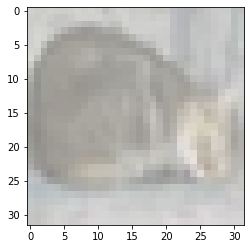

true label: cat
predict label: frog
index number: 1


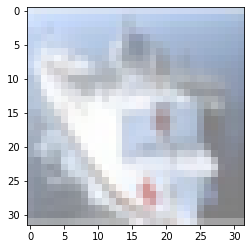

true label: ship
predict label: ship
index number: 2


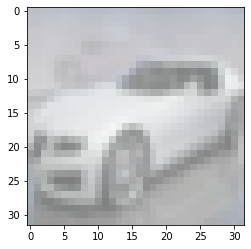

true label: car
predict label: car
index number: 3


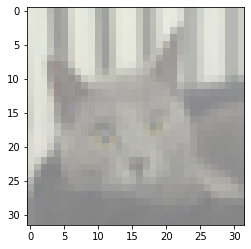

true label: cat
predict label: cat
index number: 4


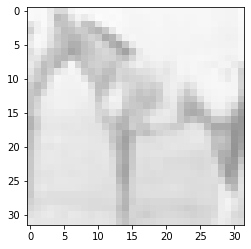

true label: horse
predict label: horse
index number: 5


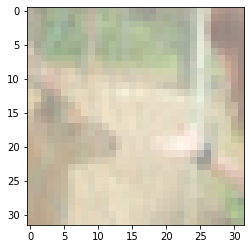

true label: deer
predict label: frog
index number: 6


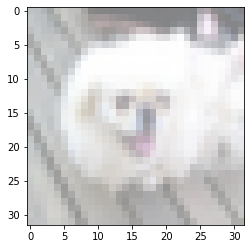

true label: dog
predict label: dog
index number: 7


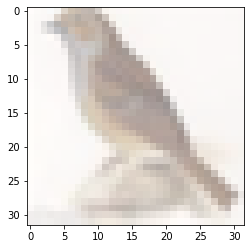

true label: bird
predict label: bird
index number: 8


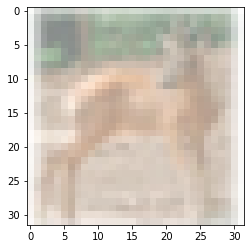

true label: deer
predict label: deer
index number: 9


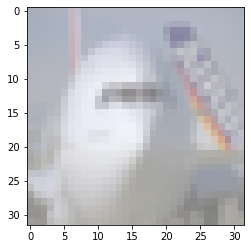

true label: plane
predict label: bird
index number: 10


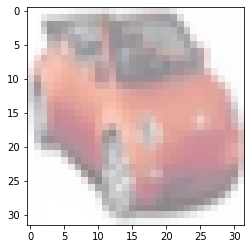

true label: car
predict label: car
index number:  


In [17]:
while True:
    i = input("index number: ")
    if i == ' ':
        break
    i = int(i)
    imshow(torchvision.utils.make_grid(images[i]))
    print('true label:',classes[labels[i]])
    prediction = model(images.to(device=device))
    max_index = np.argmax(prediction[i,:].cpu().detach().numpy())
    print('predict label:',classes[max_index])